In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Cost of Decoupled Namespace

1 server 1 client

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    try: return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    except: return float(0)

In [3]:
def mdtest(fname):
    with open(fname) as f:
        start = end = ""
        data = json.load(f)
        for line in data['stdout_lines']:
            if "started" in line: start = line.split()[4]
            if "finished" in line: end = line.split()[4]
        result = to_seconds(end) - to_seconds(start)
        if result < 0: return 0
        return result    

job,decoupled-fail,decoupled-reset,decoupled-apply,decoupled-persist,global,decoupled-nomerge
nfile,,,,,,
10.0,0.0,0.152705,0.156624,0.326289,0.0,0.169900
100.0,0.0,0.141773,0.156213,1.492069,0.0,0.135461
1000.0,0.0,0.149555,0.160972,12.937928,1.0,0.189642
10000.0,0.0,0.150882,0.161665,127.035889,15.0,0.387503
100000.0,0.0,0.161974,6.197614,1265.289542,152.0,2.569361


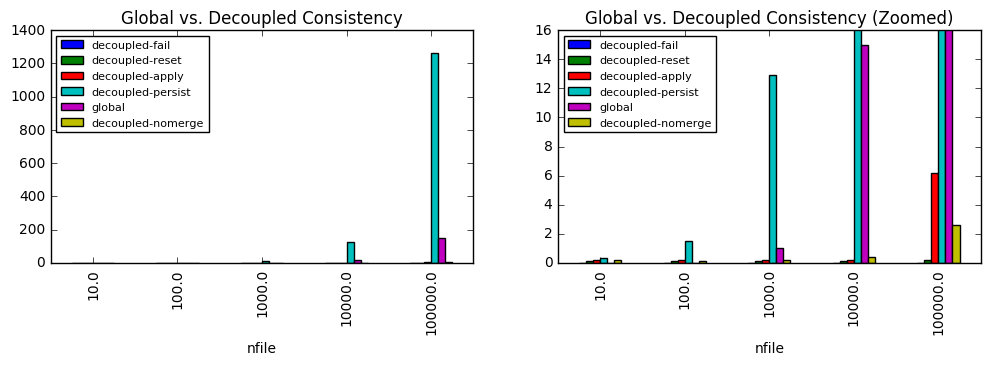

In [4]:
exp = "experiments/fuse/batchfs/results-0/"
plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
df = pd.DataFrame(columns=['job', 'nfile', 'rtime'])
for nfiles in ['10', '100', '1000', '10000', '100000']:
    with open(exp + nfiles + '/summary.txt') as f:
        d = pd.read_csv(f, names=['job', 'time', 'delta'])
        d['rtime'] = d['delta'].apply(to_seconds)
        d['nfile'] = np.full(len(d), nfiles)
        del d['time'], d['delta']
        df = df.append(d, ignore_index=True)
    df.loc[len(df)] = ["global"] + [float(nfiles)] + [mdtest(exp + nfiles + "/baseline-touch.txt")]
df = df.pivot(index='nfile', values='rtime', columns='job')
cols = df.columns.tolist()
cols = ['decoupled-fail', 'decoupled-reset', 'decoupled-apply', 'decoupled-persist', 'global', 'decoupled-nomerge']
df = df[cols]

df.plot.bar(ax=ax[0])
ax[0].set_title("Global vs. Decoupled Consistency")

#del df['decoupled-persist']#, df['decoupled-apply'], df['decoupled-reset'], df['decoupled-fail']
df.plot.bar(ax=ax[1])
ax[1].set_title("Global vs. Decoupled Consistency (Zoomed)")

ax[0].legend(fontsize=8, loc='upper left')
ax[1].legend(fontsize=8, loc='upper left')
ax[1].set_ylim(0, 16)
df

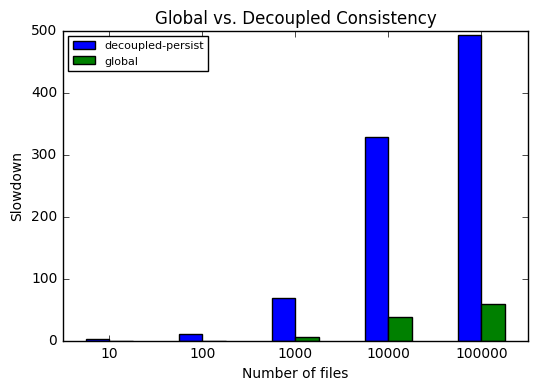

In [111]:
exp = "experiments/fuse/batchfs/results-0/"
df = pd.DataFrame(columns=['job', 'nfile', 'rtime'])

# read the results
for nfiles in ['10', '100', '1000', '10000', '100000']:
    with open(exp + nfiles + '/summary.txt') as f:
        d = pd.read_csv(f, names=['job', 'time', 'delta'])
        d['rtime'] = d['delta'].apply(to_seconds)
        d['nfile'] = np.full(len(d), nfiles)
        del d['time'], d['delta']
        df = df.append(d, ignore_index=True)
    df.loc[len(df)] = ["global"] + [float(nfiles)] + [mdtest(exp + nfiles + "/baseline-touch.txt")]
    
# massage and normalize values
df = df.pivot(index='nfile', values='rtime', columns='job')
df = df[:].div(df['decoupled-nomerge'], axis=0)
del df['decoupled-nomerge'], df['decoupled-fail'], df['decoupled-apply'], df['decoupled-reset']

# it's graph time
fig, ax = plt.subplots(1, 1)
df.plot.bar(ax=ax)

# format the graphs
ax.set_title("Global vs. Decoupled Consistency")
ax.legend(fontsize=8, loc='upper left')
ax.set_xticklabels([10, 100, 1000, 10000, 100000], rotation=0)
ax.set_ylabel("Slowdown")
#ax.set_yscale('log')
ax.set_xlabel("Number of files")

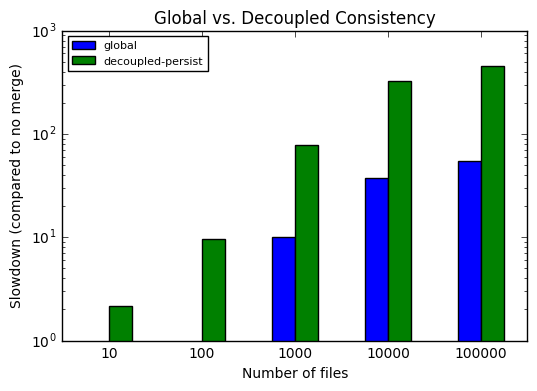

In [131]:
exp = "experiments/fuse/batchfs/results-"
df = pd.DataFrame(columns=['job', 'nfile', 'rtime'])

# read the results
jobs = []
for nfiles in ['10', '100', '1000', '10000', '100000']:
    for run in ['run0', 'run1', 'run2']:
        with open(exp + run + '/' + nfiles + '/summary.txt') as f:
            d = pd.read_csv(f, names=['job', 'time', 'delta'])
            d['rtime'] = d['delta'].apply(to_seconds)
            d['nfile'] = np.full(len(d), nfiles)
            if len(jobs) == 0:
                jobs = d['job'].copy()
                jobs[len(jobs)] = 'global'
            d['job'] = d['job'] + '-' + run
            del d['time'], d['delta']
            df = df.append(d, ignore_index=True)
        df.loc[len(df)] = ['global' + '-' + run] + [float(nfiles)] + [mdtest(exp + run + '/' + nfiles + "/baseline-touch.txt")]

# massage, get means, normalize values
df = df.pivot(index='nfile', values='rtime', columns='job')
for job in jobs:
    df[job] = df[[job + s for s in runs]].mean(axis=1)
df = df[:].div(df['decoupled-nomerge'], axis=0)

# it's graph time
fig, ax = plt.subplots(1, 1)
df.plot.bar(y=['global', 'decoupled-persist'], yerr=error, ax=ax)

# format the graphs
ax.set_title("Global vs. Decoupled Consistency")
ax.legend(fontsize=8, loc='upper left')
ax.set_xticklabels([10, 100, 1000, 10000, 100000], rotation=0)
ax.set_ylabel("Slowdown (compared to no merge)")
ax.set_yscale('log')
ax.set_xlabel("Number of files")